
# Project: Advance Lane Finding

#### **The goals / steps of this project are the following:**

- **Compute the camera calibration matrix and distortion coefficients given a set of chessboard images.**
- **Apply a distortion correction to raw images.**
- **Use color transforms, gradients, etc., to create a thresholded binary image.**
- **Apply a perspective transform to rectify binary image ("birds-eye view").**
- **Detect lane pixels and fit to find the lane boundary.**
- **Determine the curvature of the lane and vehicle position with respect to center.**
- **Warp the detected lane boundaries back onto the original image.**
- **Output visual display of the lane boundaries and numerical estimation of lane curvature and vehicle position.**

In [6]:
#Importing libraries
import numpy as np
import cv2
import math
import glob
import pickle
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
%matplotlib inline


In [7]:
#extract frames from video
def frames_from_video(filename):
    cap = cv2.VideoCapture(filename)
    frameRate = cap.get(1)
    x=1
    while(cap.isOpened()):
        frameId = cap.get(1) #current frame number
        ret, frame = cap.read()
        if (ret != True):
            break
        if (frameId % math.floor(frameRate) == 0):
            filename = './images_from_video/test' +  str(int(x)) + ".jpg";x+=1
            cv2.imwrite(filename, frame)

    cap.release()
    print ("Done!")

In [103]:
filename="project_video.mp4"
frames_from_video(filename)

Done!


## 1.Camera Calibration
- corners detection
- camera calibration
- calculate distortion coefficents
- apply a distortion correction to raw images 

In [9]:
# variables
objp = np.zeros((6*9,3), np.float32)
objp[:,:2] = np.mgrid[0:9,0:6].T.reshape(-1,2)
objpoints = [] # 3d points in real world space
imgpoints = [] # 2d points in image plane.
images = glob.glob('camera_cal/calibration*.jpg')
img_size = (1280, 720)


In [10]:

def camera_calibration():
    for fname in images:
        img = cv2.imread(fname)
        gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)

        # Find the chessboard corners
        ret, corners = cv2.findChessboardCorners(gray, (9,6),None)

        # If found, add object points, image points
        if ret == True:
            objpoints.append(objp)
            imgpoints.append(corners)

            # Draw and display the corners
            img = cv2.drawChessboardCorners(img, (9,6), corners, ret)
            plt.imshow(img)
            #cv2.imshow('img',img)
            #cv2.waitKey(500)
    #cv2.destroyAllWindows()

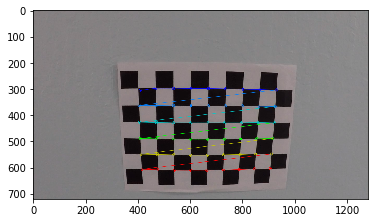

In [11]:
camera_calibration()


In [12]:
# global variables mtx,dist
ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, img_size,None,None)

In [13]:
# test undistortion
def plot_undistorted(img):
    corr = cv2.undistort(img, mtx, dist, None, mtx)
    corr= cv2.cvtColor(corr, cv2.COLOR_BGR2RGB)
    f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))
    ax1.imshow(img)
    ax1.set_title('Original Image', fontsize=30)
    ax2.imshow(corr)
    ax2.set_title('Undistorted Image', fontsize=30)


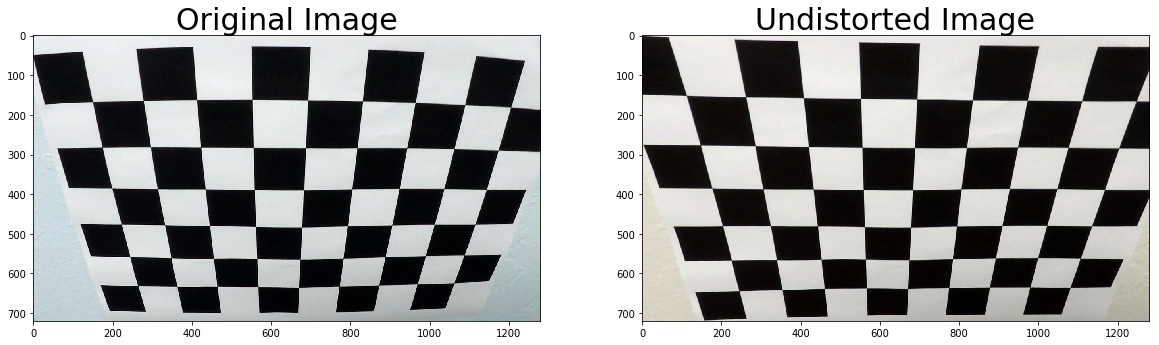

In [14]:
img = cv2.imread('camera_cal/calibration2.jpg')
plot_undistorted(img)


In [15]:
import os 
test_images=os.listdir("test_images/")
test_images

['_test3.jpg',
 'test2.jpg',
 '_test6.jpg',
 '__straight_lines1.jpg',
 '__test2.jpg',
 'test1.jpg',
 '__test3.jpg',
 'test6.jpg',
 '__test1.jpg',
 'test5.jpg',
 'straight_lines2.jpg',
 '_test4.jpg',
 '_straight_lines1.jpg',
 '__straight_lines2.jpg',
 'test3.jpg',
 'straight_lines1.jpg',
 '__test4.jpg',
 '_test1.jpg',
 '_straight_lines2.jpg',
 '_test5.jpg',
 '_test2.jpg',
 '__test6.jpg',
 'test4.jpg',
 '__test5.jpg']

In [16]:
#very important  mtx, dist variables
def distortion_correction(img):
    out = cv2.undistort(img, mtx, dist, None, mtx)
    return out

#### Apply a distortion correction to raw images:

In [17]:
def apply_distortion():
    for fname in test_images:
        img = cv2.imread('test_images/'+fname)
        corr = cv2.undistort(img, mtx, dist, None, mtx)
        cv2.imwrite('test_images/_'+fname,corr)
    print("Correction Done!")
apply_distortion()

Correction Done!


In [18]:
def plot_distortion_correction(img,correction):
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    correction = cv2.cvtColor(correction, cv2.COLOR_BGR2RGB)
    f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
    f.tight_layout()
    ax1.imshow(img)
    ax1.set_title('Original Image', fontsize=50)
    ax2.imshow(correction)
    ax2.set_title('Undistorted Image', fontsize=50)
    plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

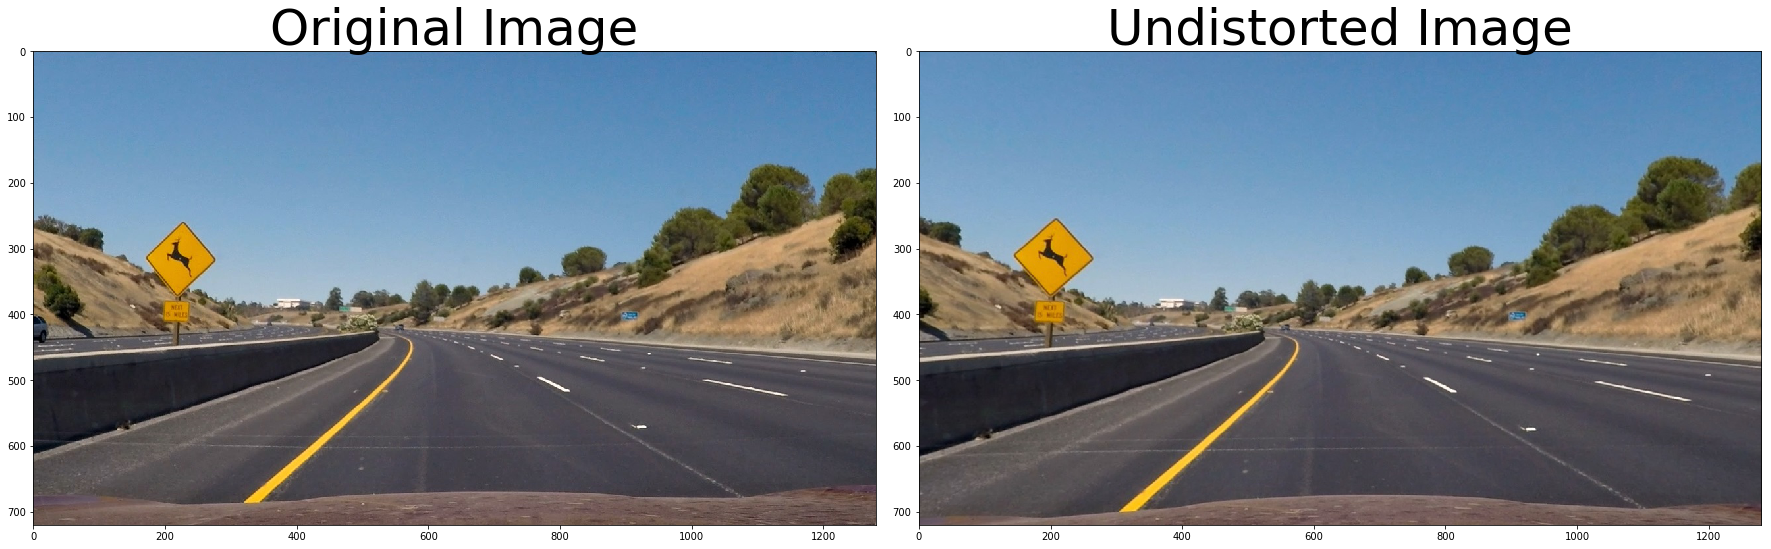

In [19]:

img = cv2.imread('test_images/test2.jpg')
correction= cv2.imread('test_images/_test2.jpg')
plot_distortion_correction(img,correction)

### 2.Color transforms and gradients transform 

### Helper functions:

In [20]:
#Global variables

In [21]:
points = np.array([[580,469],
                   [280,679],
                   [750,467], 
                   [1070, 676]], np.int32)
src = points.astype(np.float32)
(x_len, y_len) = (720,1280) 
dst = np.array([[200, 0], 
                [200, 680], 
                [1000, 0],
                [1000, 680]], np.float32)

In [22]:
def abs_sobel_thresh(img, orient='x', sobel_kernel=3, thresh=(0, 255)):
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    scaled_sobel = None
    
    # Sobel x
    if orient == 'x':
        sobel = cv2.Sobel(gray, cv2.CV_64F, 1, 0,ksize=sobel_kernel) 
        
    # Sobel y
    else:
        sobel = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel) 

    abs_sobel = np.abs(sobel)
    scaled_sobel = np.uint8(255*abs_sobel/np.max(abs_sobel))     

    # Threshold x gradient
    thresh_min = thresh[0]
    thresh_max = thresh[1]
    grad_binary = np.zeros_like(scaled_sobel)
    grad_binary[(scaled_sobel >= thresh_min) & (scaled_sobel <= thresh_max)] = 1
    
    return grad_binary

def mag_thresh(img, sobel_kernel=3, thresh_mag=(0, 255)):
    
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0,ksize=sobel_kernel)
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1,ksize=sobel_kernel)
    
    magnitude = np.sqrt(sobelx**2 + sobely**2)

    scaled_magnitude = np.uint8(255*magnitude/np.max(magnitude))
    mag_binary = np.zeros_like(scaled_magnitude)
    mag_binary[(scaled_magnitude >= thresh_mag[0]) & (scaled_magnitude <= thresh_mag[1])] = 1
    
    return mag_binary

def dir_threshold(img, sobel_kernel=3, dir_thresh=(0, np.pi/2)):
    
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0,ksize=sobel_kernel)
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1,ksize=sobel_kernel)
    abs_sobelx = np.absolute(sobelx)
    abs_sobely = np.absolute(sobely)
    arctan = np.arctan2(abs_sobely, abs_sobelx)
    dir_binary = np.zeros_like(arctan)
    dir_binary[(arctan >= dir_thresh[0]) & (arctan <= dir_thresh[1])] = 1
    
    return dir_binary

def warp_transform(img):   

    img_size = (img.shape[1], img.shape[0])
    M = cv2.getPerspectiveTransform(src, dst)
    warped = cv2.warpPerspective(img, M, img_size, flags=cv2.INTER_LINEAR)
    
    return warped
def combine_L_B(img,l_thresh=(218,255),b_thresh=(185,255)):
    
    hls = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
    hls_l = hls[:,:,1]
    
    hls_l = hls_l*(255/np.max(hls_l))
    l_binary = np.zeros_like(hls_l)
    l_binary[(hls_l > l_thresh[0]) & (hls_l <= l_thresh[1])] = 1
  
    # converting to LAB
    lab = cv2.cvtColor(img, cv2.COLOR_RGB2Lab)
    lab_b = lab[:,:,2]
    
    #The LAB Color-Space

    #L – Lightness ( Intensity ).
    #a – color component ranging from Green to Magenta.
    #b – color component ranging from Blue to Yellow.
    # skip yellow
    if np.max(lab_b) > 175:
        lab_b = lab_b*(255/np.max(lab_b))
   
    b_binary = np.zeros_like(lab_b)
    b_binary[((lab_b > b_thresh[0]) & (lab_b <= b_thresh[1]))] = 1
    
    result = np.zeros_like(l_binary)
    result[(l_binary==1) | (b_binary == 1)] = 1

    return result
def color_transformation(img, color_thresh=(175, 255)):
    
      
    hls_image = cv2.cvtColor(img, cv2.COLOR_BGR2HLS).astype(np.float)
    l_channel = hls_image[:,:,1]
    s_channel = hls_image[:,:,2]
    
  
    hsv_image = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)

    white_color = cv2.inRange(hls_image, np.uint8([10,200,0]), np.uint8([255,255,255]))
    yellow_color = cv2.inRange(hsv_image, np.uint8([15,60,130]), np.uint8([150,255,255]))
    
    combined_color_images = cv2.bitwise_or(white_color, yellow_color)
    
   
    s_binary = np.zeros_like(s_channel)
    s_binary[(s_channel >= color_thresh[0]) & (s_channel <= color_thresh[1])] = 1

    l_binary = np.zeros_like(l_channel)
    l_binary[(l_channel >= 100) & (l_channel <= color_thresh[1])] = 1


    combined_binary = np.zeros_like(s_channel)
    combined_binary[((s_binary > 0) & (l_binary > 0)) | (combined_color_images > 0)] = 1

    return combined_binary


### 2.1. Gradient Thresholding (Sobel X,Y,Magnitude,Direction)

In [23]:
magnitude_thresh = (30,100)
direction_thresh = (0.8,1.1)
ksize=3

#visualise Sobel transformation
def sobel(img):
    x_binary = abs_sobel_thresh(img, orient='x', thresh=(40,100))
    y_binary = abs_sobel_thresh(img, orient='y', thresh=(40,100))
    mag_binary = mag_thresh(img,sobel_kernel=ksize, thresh_mag=magnitude_thresh )
    dir_binary = dir_threshold(img, sobel_kernel=ksize , dir_thresh = direction_thresh)

    f, ((ax1, ax2),(ax3,ax4)) = plt.subplots(2, 2, figsize=(20, 10))
    f.tight_layout() 
    ax1.imshow(x_binary, cmap='gray')
    ax1.set_title('Sobel X', fontsize=20)
    ax2.imshow(y_binary, cmap='gray')
    ax2.set_title('Sobel Y', fontsize=12)
    ax3.imshow(mag_binary , cmap='gray')
    ax3.set_title('Magnitude', fontsize=20)
    ax4.imshow(dir_binary, cmap='gray')
    ax4.set_title('Direction', fontsize=20)

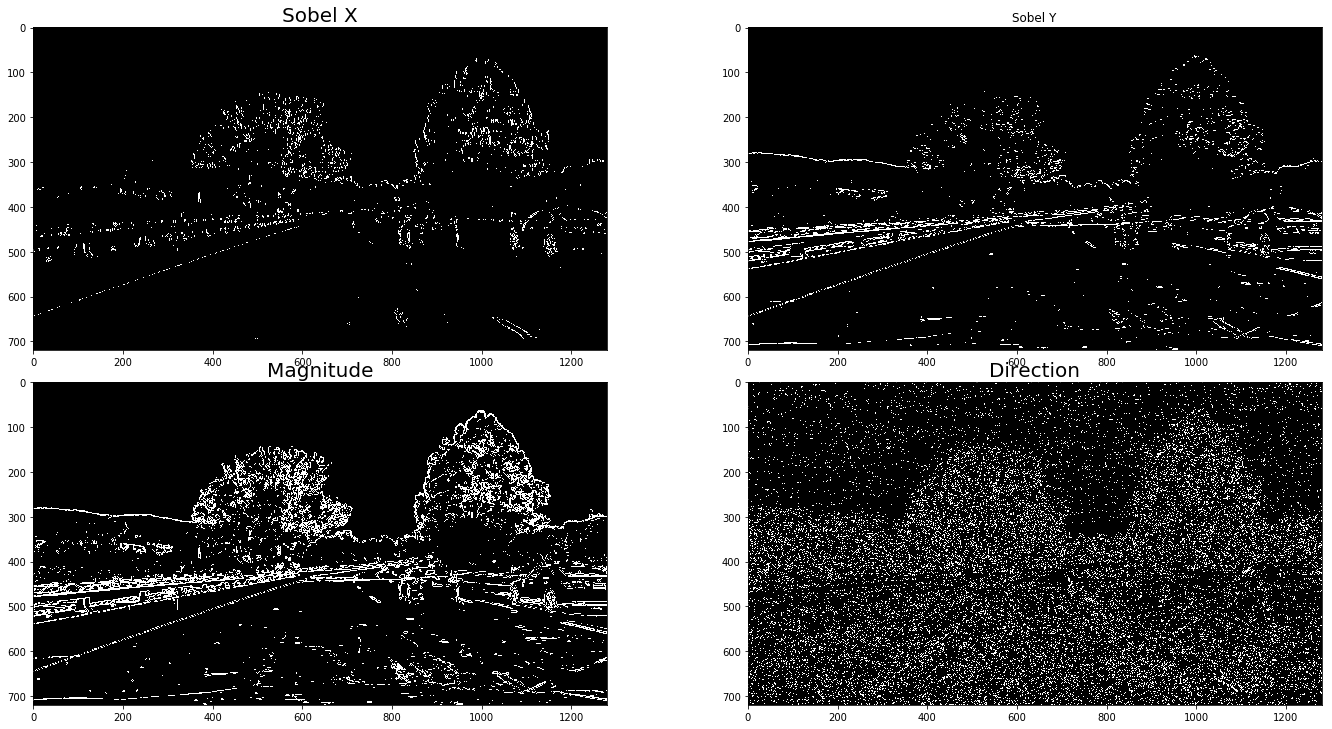

In [24]:
img = cv2.imread('test_images/_test1.jpg')
sobel(img)

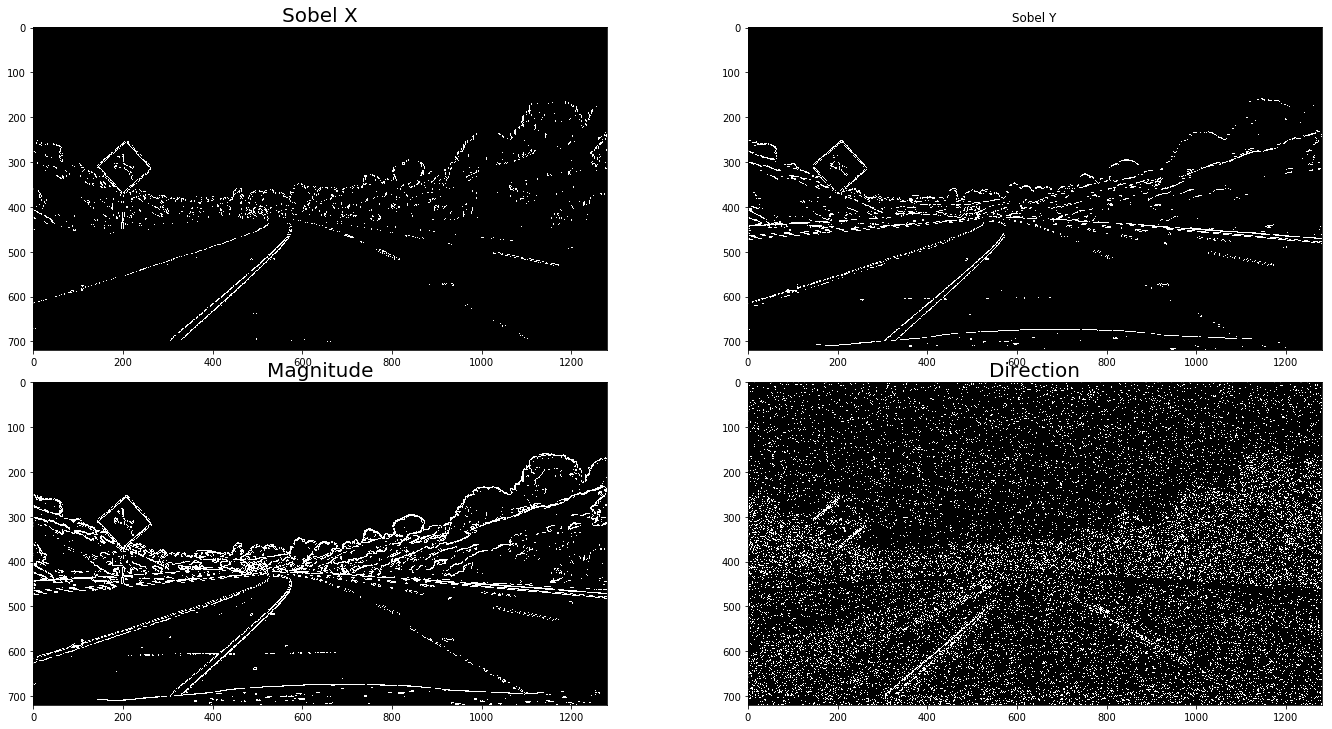

In [25]:
img = cv2.imread('test_images/_test2.jpg')
sobel(img)

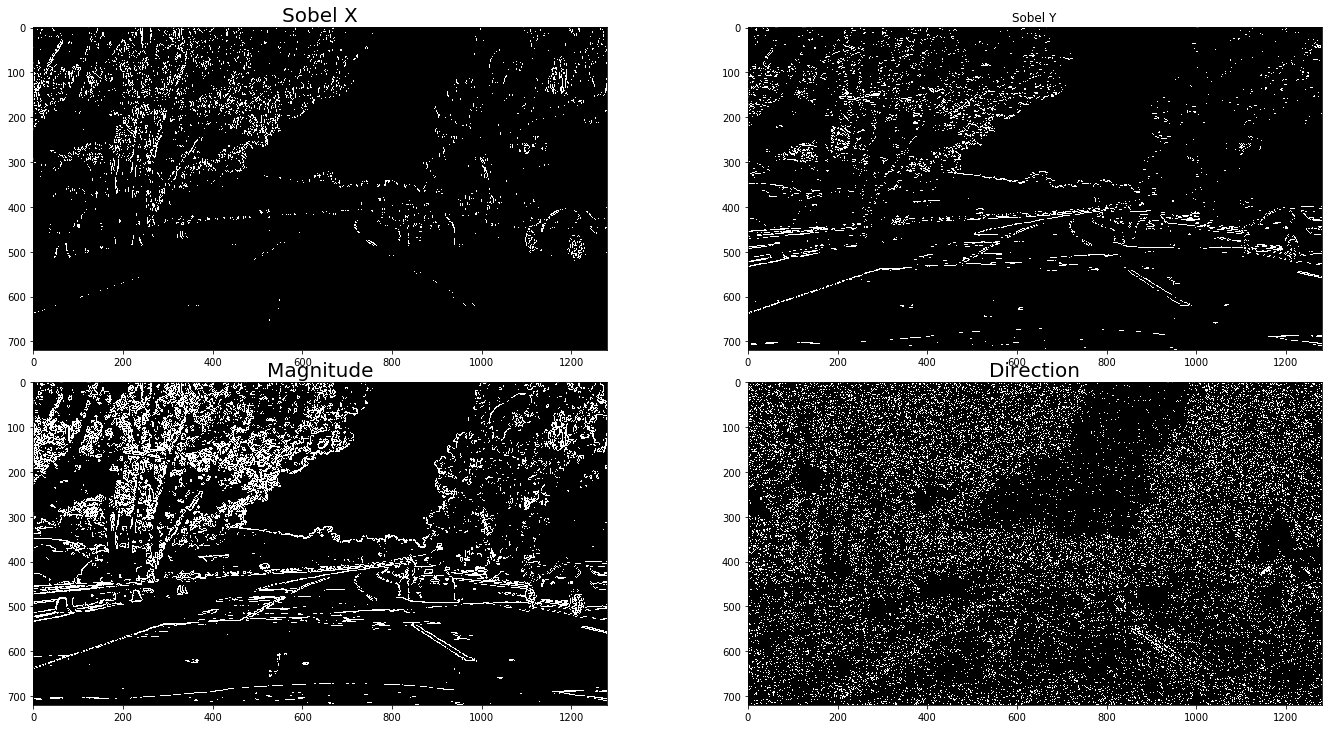

In [26]:
img = cv2.imread('test_images/_test5.jpg')
sobel(img)

### 2.1.1 Combined Thresholding

Text(0.5,1,'Combined Gradient Threshold ')

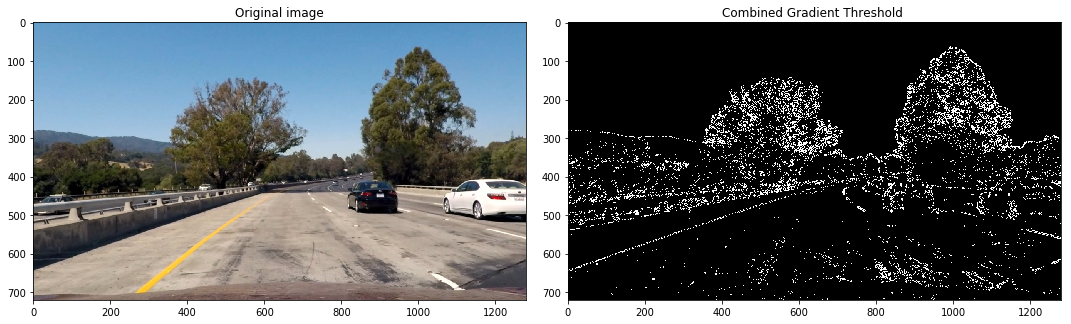

In [27]:
sobel_thresh = (12,100)
thresh_mag = (80,100)
dir_thresh = (0.8,1.2)
kernel_size=3

img1 = cv2.imread('test_images/_test1.jpg')
img2 = cv2.imread('test_images/_straight_lines1.jpg')

gradx = abs_sobel_thresh(img1, orient='x', sobel_kernel=ksize, thresh=sobel_thresh)
grady = abs_sobel_thresh(img1, orient='y', sobel_kernel=ksize, thresh=sobel_thresh)
mag_binary = mag_thresh(img1, sobel_kernel=ksize, thresh_mag = thresh_mag)
dir_binary = dir_threshold(img1, sobel_kernel=ksize, dir_thresh=dir_thresh)

sx_binary= np.zeros_like(dir_binary)
sx_binary[((gradx == 1) & (grady == 1)) | ((mag_binary == 1) & (dir_binary == 1))] = 1

#Display results
f, ((ax1, ax2)) = plt.subplots(1, 2, figsize=(15, 9))
f.tight_layout()
img1 = cv2.cvtColor(img1, cv2.COLOR_BGR2RGB)
ax1.imshow(img1)
ax1.set_title('Original image', fontsize=12)

ax2.imshow(sx_binary, cmap='gray')
ax2.set_title('Combined Gradient Threshold ', fontsize=12)


### 2.2 Color Thresholding (color extraction for yellow and white, using the HLS and HSV)

Text(0.5,1,'Color Thresholding')

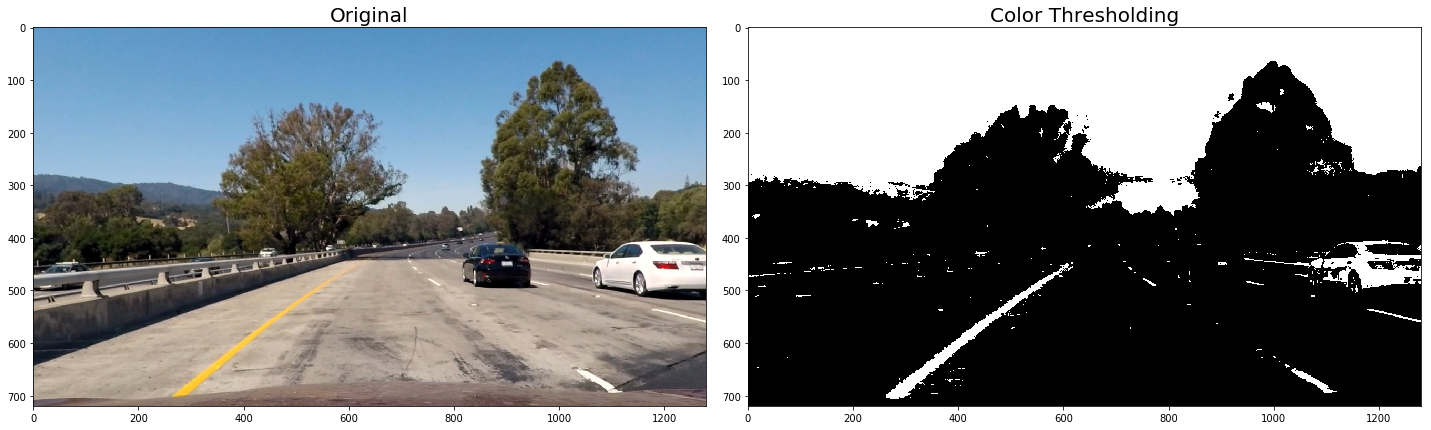

In [28]:
thresh = (170, 255)
img = cv2.imread('test_images/_test1.jpg')

color_binary = color_transformation(img, color_thresh=thresh)

img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
f, ((ax1, ax2)) = plt.subplots(1, 2, figsize=(20, 10))
f.tight_layout()
ax1.imshow(img)
ax1.set_title('Original', fontsize=20)
ax2.imshow(color_binary, cmap='gray')
ax2.set_title('Color Thresholding', fontsize=20)


### 2.2.1 Color Thresholding (color extraction for B and L channel using the LAB color space)

Text(0.5,1,'Color Thresholding ')

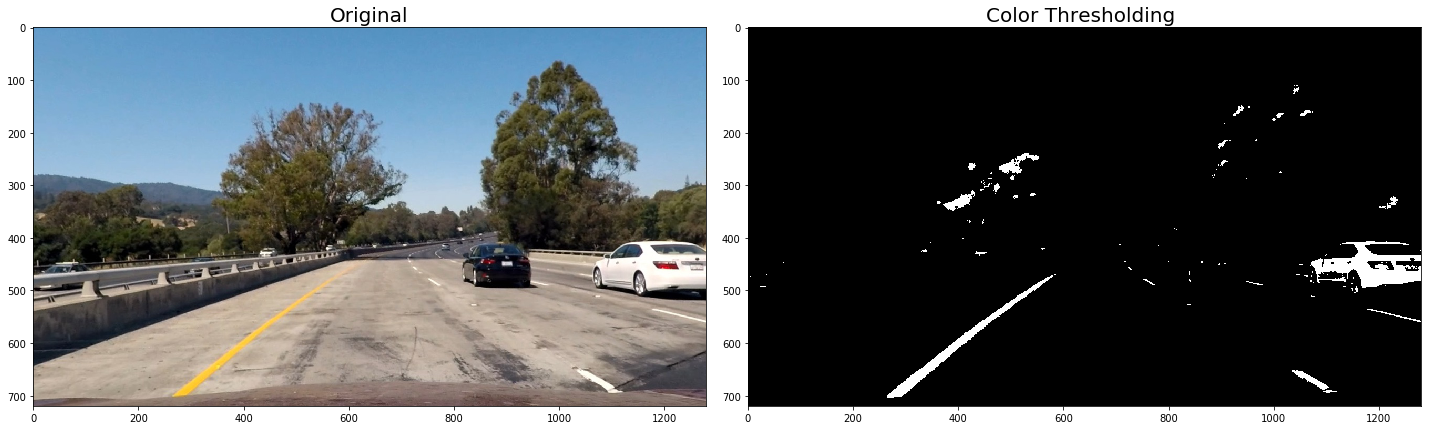

In [29]:
img = cv2.imread('test_images/_test1.jpg')
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
color_binary = combine_L_B(img)
f, ((ax1, ax2)) = plt.subplots(1, 2, figsize=(20, 10))
f.tight_layout()
ax1.imshow(img)
ax1.set_title('Original', fontsize=20)
ax2.imshow(color_binary,cmap='gray')
ax2.set_title('Color Thresholding ', fontsize=20)


Text(0.5,1,'Color Thresholding ')

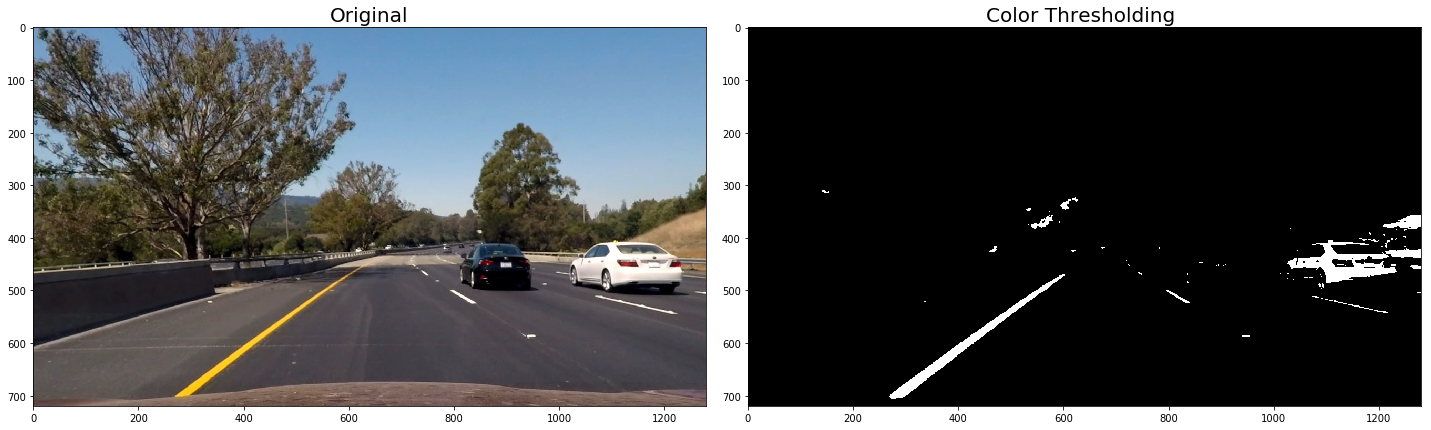

In [30]:
img = cv2.imread('test_images/_test6.jpg')
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
color_binary = combine_L_B(img)
f, ((ax1, ax2)) = plt.subplots(1, 2, figsize=(20, 10))
f.tight_layout()
ax1.imshow(img)
ax1.set_title('Original', fontsize=20)
ax2.imshow(color_binary,cmap='gray')
ax2.set_title('Color Thresholding ', fontsize=20)

Text(0.5,1,'Color Thresholding HLS')

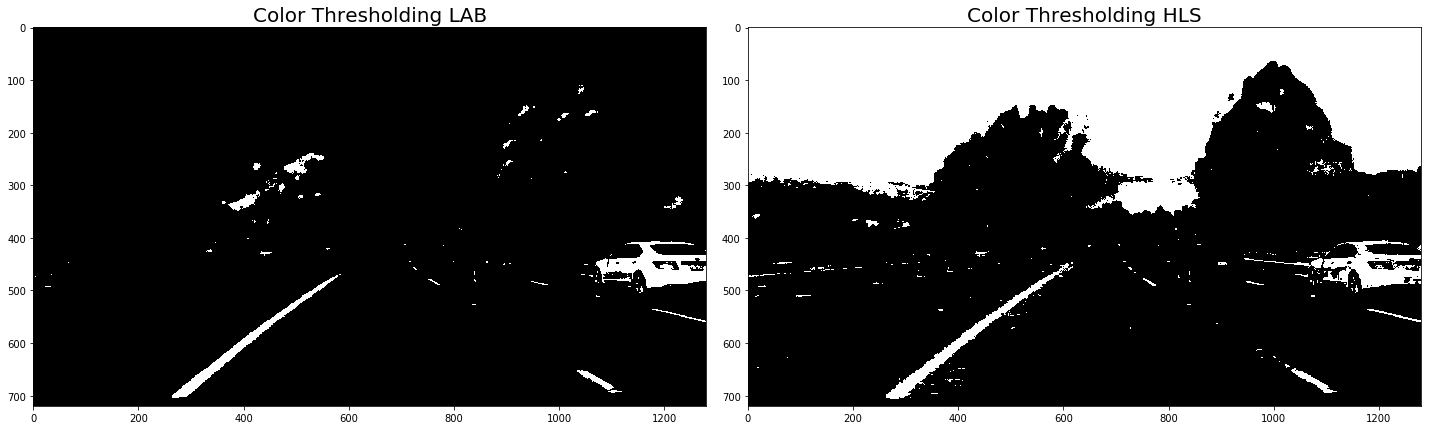

In [31]:
thresh = (170, 255)
img = cv2.imread('test_images/_test1.jpg')
img1 = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
lab_binary = combine_L_B(img1)
hls_binary = color_transformation(img, color_thresh=thresh)
f, ((ax1, ax2)) = plt.subplots(1, 2, figsize=(20, 10))
f.tight_layout()
ax1.imshow(lab_binary,cmap='gray')
ax1.set_title('Color Thresholding LAB', fontsize=20)
ax2.imshow(hls_binary,cmap='gray')
ax2.set_title('Color Thresholding HLS', fontsize=20)

### 3.Perspective transform ("birds-eye view")

In [32]:
def transform(img1,img2):
    warped1=warp_transform(img1)
    warped2=warp_transform(img2)
    color_binary = color_transformation(warped1)
    extract_l_b=combine_L_B(warped2)
    f, ((ax1, ax2,ax3)) = plt.subplots(1, 3, figsize=(15, 10))
    f.tight_layout()
    ax1.imshow(img2)
    ax1.set_title('Original', fontsize=12)
    ax2.imshow(color_binary, cmap='gray')
    ax2.set_title('Warped & Color (selecting yellow & white)', fontsize=12)
    ax3.imshow(extract_l_b,cmap='gray')
    ax3.set_title('Warped & LAB (L & B channel)', fontsize=12)


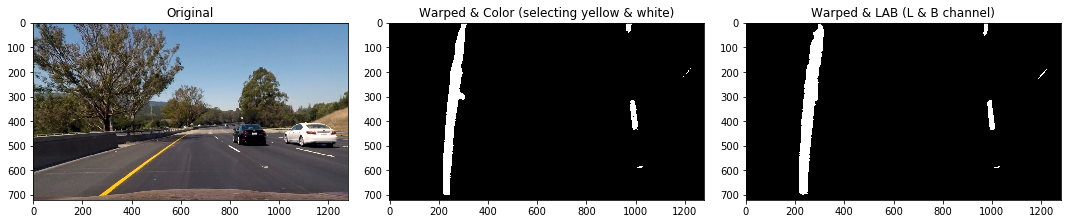

In [33]:
img1 = cv2.imread('test_images/_test6.jpg')
img2 = mpimg.imread('test_images/_test6.jpg')
transform(img1,img2)


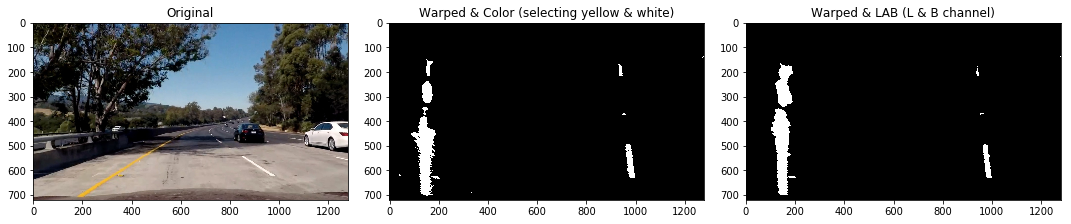

In [34]:
img1 = cv2.imread('test_images/_test5.jpg')
img2 = mpimg.imread('test_images/_test5.jpg')
transform(img1,img2)


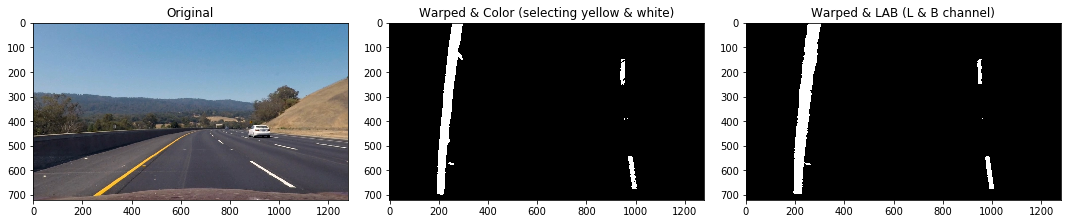

In [35]:
img1 = cv2.imread('test_images/_test3.jpg')
img2 = mpimg.imread('test_images/_test3.jpg')
transform(img1,img2)


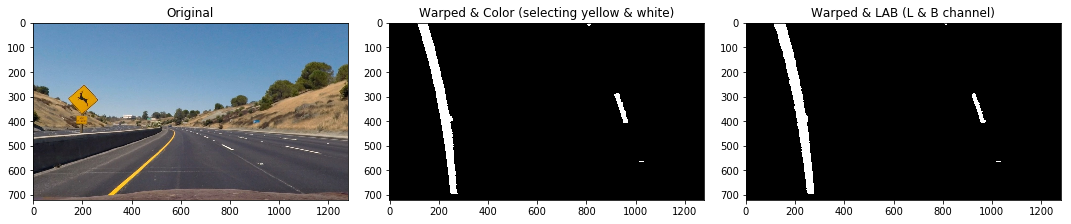

In [36]:
img1 = cv2.imread('test_images/_test2.jpg')
img2 = mpimg.imread('test_images/_test2.jpg')
transform(img1,img2)

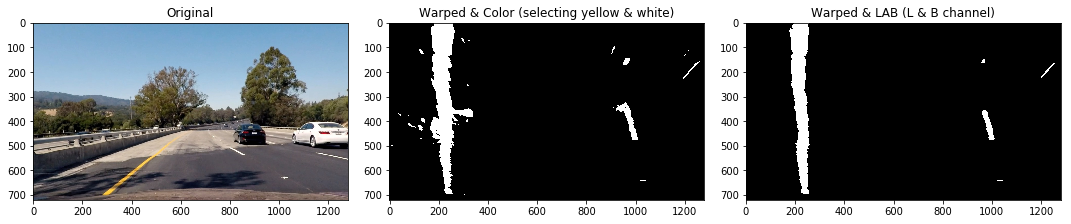

In [37]:
img1 = cv2.imread('test_images/_test4.jpg')
img2 = mpimg.imread('test_images/_test4.jpg')
transform(img1,img2)

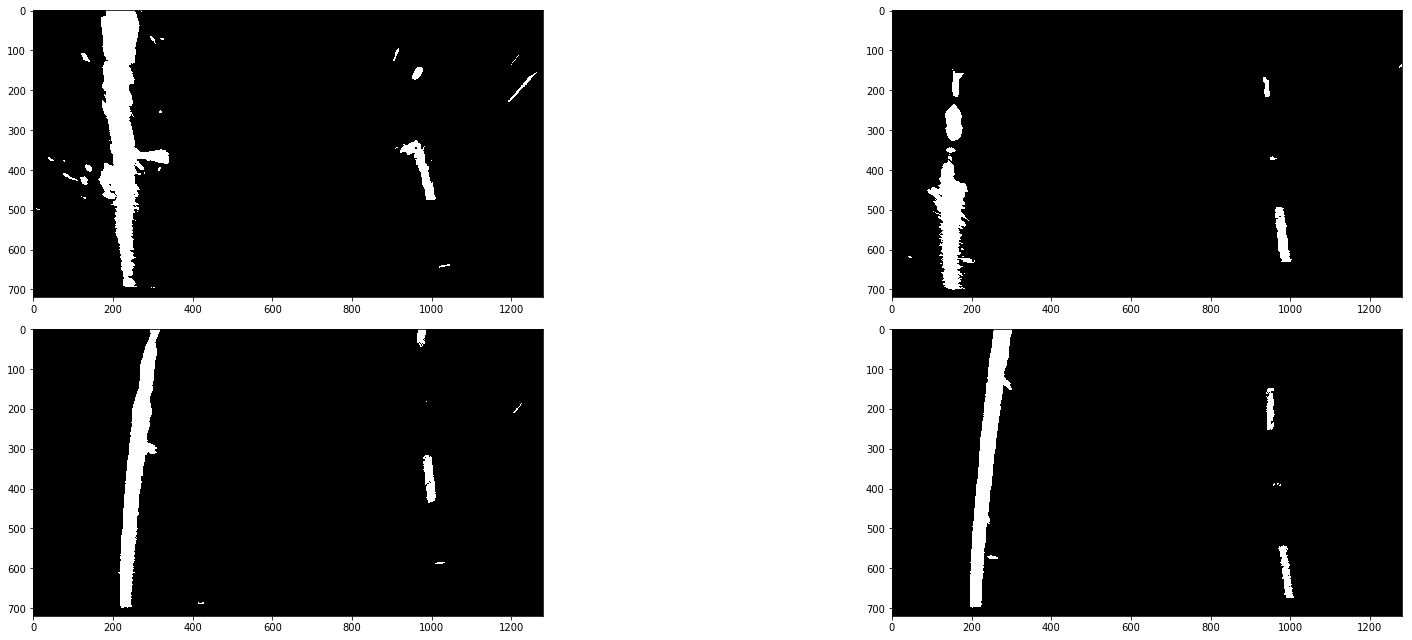

In [38]:
def display_image_transformation():
    img1 = cv2.imread('test_images/_test4.jpg')
    img2 = cv2.imread('test_images/_test5.jpg')
    img3 = cv2.imread('test_images/_test6.jpg')
    img4 = cv2.imread('test_images/_test3.jpg')

    warped1=warp_transform(img1)
    warped2=warp_transform(img2)
    warped3=warp_transform(img3)
    warped4=warp_transform(img4)
    binary1 = color_transformation(warped1)
    binary2 = color_transformation(warped2)
    binary3 = color_transformation(warped3)
    binary4 = color_transformation(warped4)
    f, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(24, 9))
    f.tight_layout()
    ax1.imshow(binary1, cmap='gray')
    ax2.imshow(binary2, cmap='gray')
    ax3.imshow(binary3, cmap='gray')
    ax4.imshow(binary4, cmap='gray')

display_image_transformation()


### 4.Detect lane pixels and fit to find the lane boundary.
 - **Find the peaks in a histogram**
 - **Split the historam in two lines**
 - **Find lane pixels**

Text(0.5,1,'Histogram')

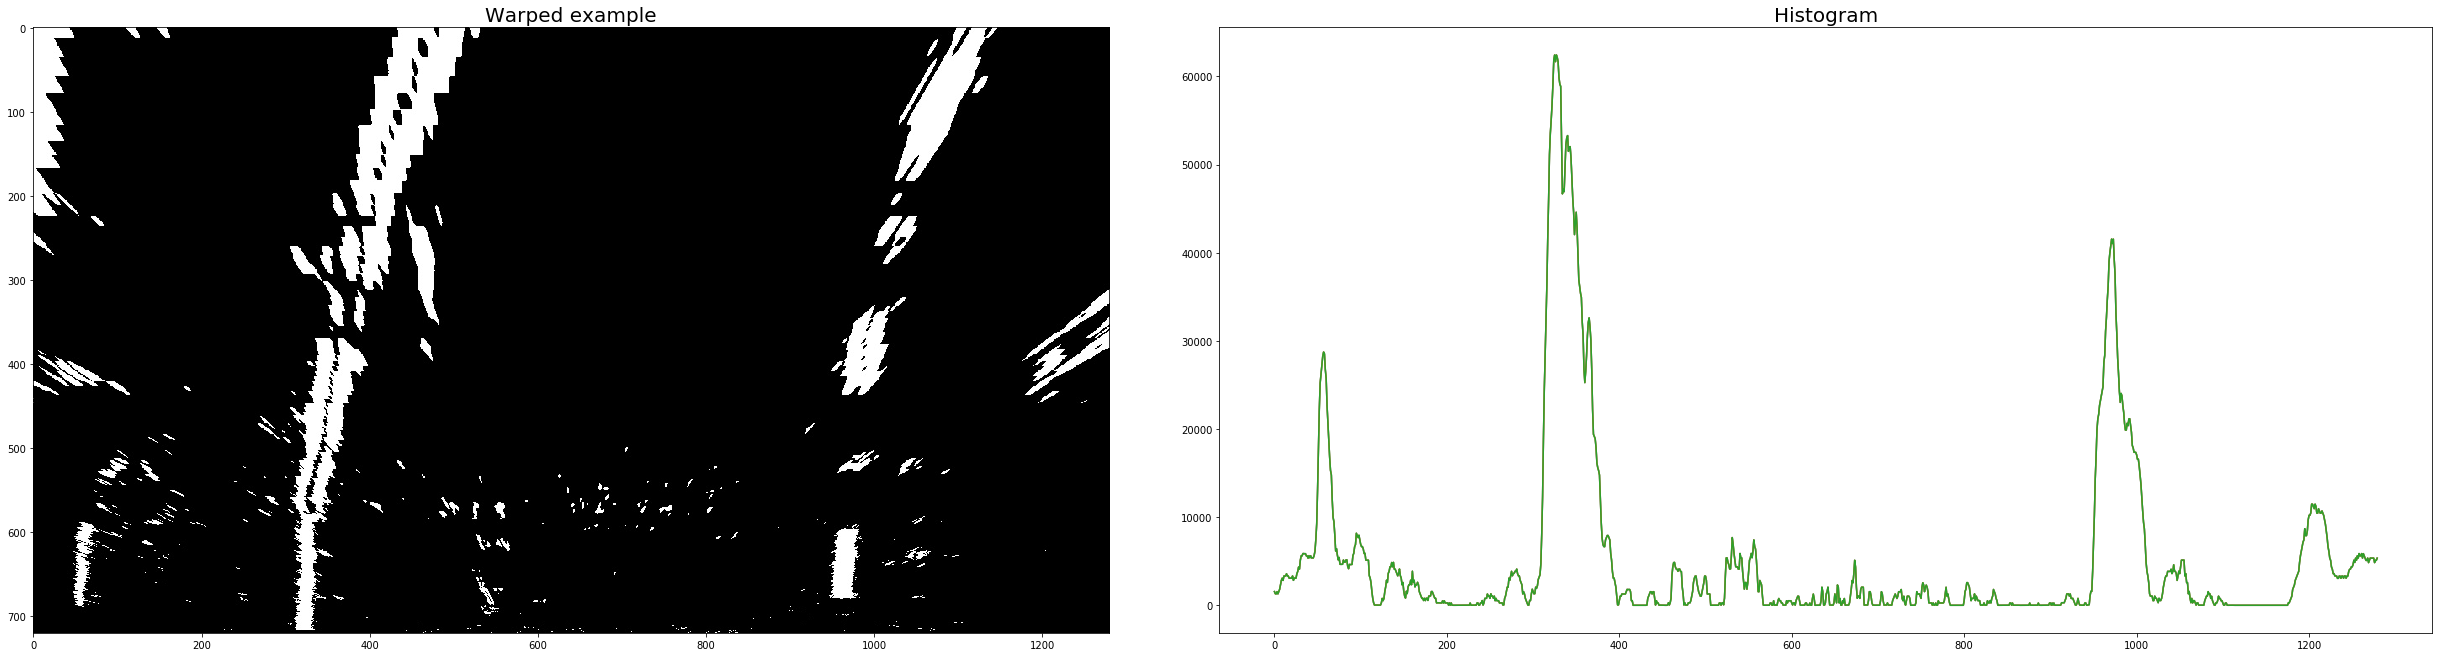

In [39]:
def hist(img):
    bottom_half = img[img.shape[0]//2:,:]
    histogram = np.sum(bottom_half, axis=0)
    return histogram

img1 = cv2.imread('output_images/warped-example.jpg')
histogram = hist(img1)
f, ((ax1, ax2)) = plt.subplots(1, 2, figsize=(35, 9))
f.tight_layout()
ax1.imshow(img1, cmap='gray')
ax1.set_title('Warped example',fontsize=20)
ax2.plot(histogram)
ax2.set_title('Histogram',fontsize=20)

In [136]:

def  find_lane_pixels(binary_warped):
    global first_frame
    global last_left_fit
    global last_right_fit
    # Take a histogram of the bottom half of the image
    histogram = np.sum(binary_warped[binary_warped.shape[0]//2:,:], axis=0)
    midpoint = np.int(histogram.shape[0]//2)
    # Find the peak of the left and right halves of the histogram
    # These will be the starting point for the left and right lines
    leftx_base = np.argmax(histogram[:midpoint])
    rightx_base = np.argmax(histogram[midpoint:]) + midpoint
    # Choose the number of sliding windows
    nwindows = 9
    # Set height of windows
    window_height = np.int(binary_warped.shape[0]/nwindows)
    # Identify the x and y positions of all nonzero pixels in the image
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    # Current positions to be updated for each window
    leftx_current = leftx_base
    rightx_current = rightx_base
    # Set the width of the windows +/- margin
    margin = 90
    # Set minimum number of pixels found to recenter window
    minpix = 50
    # Create empty lists to receive left and right lane pixel indices
    left_lane_inds = []
    right_lane_inds = []
    rectangles = []
    # Step through the windows one by one
    for window in range(nwindows):
        
        # Identify window boundaries in x and y (and right and left)
        win_y_low = binary_warped.shape[0] - (window+1)*window_height
        win_y_high = binary_warped.shape[0] - window*window_height
        win_xleft_low = leftx_current - margin
        win_xleft_high = leftx_current + margin
        win_xright_low = rightx_current - margin
        win_xright_high = rightx_current + margin
        
        # save the windows on the visualization image
        rectangles.append((win_y_low, win_y_high, win_xleft_low, win_xleft_high, win_xright_low, win_xright_high))
        
        # Identify the nonzero pixels in x and y within the window
        good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
                          (nonzerox >= win_xleft_low) & (nonzerox < win_xleft_high)).nonzero()[0]
        good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) &
                           (nonzerox >= win_xright_low) & (nonzerox < win_xright_high)).nonzero()[0]
        
        # Append these indices to the lists
        left_lane_inds.append(good_left_inds)
        right_lane_inds.append(good_right_inds)
        
        # If you found > minpix pixels, recenter next window on their mean position
        if len(good_left_inds) > minpix:
            leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
        if len(good_right_inds) > minpix:        
            rightx_current = np.int(np.mean(nonzerox[good_right_inds]))
            
    # Concatenate the arrays of indices
    left_lane_inds = np.concatenate(left_lane_inds)
    right_lane_inds = np.concatenate(right_lane_inds)

    # Extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds] 
    
    #print("left x " ,len(leftx),leftx)
    #print("right x " ,len(rightx),rightx)
     # Fit a second order polynomial to each
   # left_fit = np.polyfit(lefty, leftx, 2)
   # right_fit = np.polyfit(righty, rightx, 2)
  
    
    if first_frame==0:
        left_fit = np.polyfit(lefty, leftx, 2)
        right_fit = np.polyfit(righty, rightx, 2)
        last_left_fit=left_fit
        last_right_fit=right_fit
        first_frame=1
        
    if first_frame==1:
        if len(leftx) != 0 and len(lefty) != 0:
            left_fit = np.polyfit(lefty, leftx, 2)
            last_left_fit = left_fit
        else:
            print("left skip")
            left_fit=last_left_fit
            #left_fit_new, right_fit_new=refit(binary_warped, last_left_fit, last_right_fit)
            #left_fit =left_fit_new
        if len(rightx) >2000:
            right_fit = np.polyfit(righty, rightx, 2)
            last_right_fit=right_fit
        else: 
            print("right skip")
            right_fit=last_right_fit
           #left_fit_new, right_fit_new=refit(binary_warped, last_left_fit, last_right_fit)
            #ight_fit =right_fit_new
            
    return left_fit, right_fit, left_lane_inds, right_lane_inds, rectangles

In [137]:
def refit(binary_warped, left_fit_prev, right_fit_prev):
    
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    margin = 80
    left_lane_inds = ((nonzerox > (left_fit_prev[0]*(nonzeroy**2) + left_fit_prev[1]*nonzeroy + left_fit_prev[2] - margin)) & 
                      (nonzerox < (left_fit_prev[0]*(nonzeroy**2) + left_fit_prev[1]*nonzeroy + left_fit_prev[2] + margin))) 
    right_lane_inds = ((nonzerox > (right_fit_prev[0]*(nonzeroy**2) + right_fit_prev[1]*nonzeroy + right_fit_prev[2] - margin)) & 
                       (nonzerox < (right_fit_prev[0]*(nonzeroy**2) + right_fit_prev[1]*nonzeroy + right_fit_prev[2] + margin)))  

    # Again, extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]
    
    left_fit_new, right_fit_new = (None, None)
    if len(leftx) != 0:
        # Fit a second order polynomial to each
        left_fit_new = np.polyfit(lefty, leftx, 2)
    if len(rightx) != 0:
        right_fit_new = np.polyfit(righty, rightx, 2)
    #return left_fit_new, right_fit_new, left_lane_inds, right_lane_inds
    return left_fit_new, right_fit_new

In [122]:
def visualize(binary_warped, left_fit,right_fit, left_lane_inds, right_lane_inds,rectangles):

    left_fit, right_fit, left_lane_inds, right_lane_inds, rectangles = find_lane_pixels(binary_warped)
    out_img = np.uint8(np.dstack((binary_warped, binary_warped, binary_warped))*255)
    # Generate x and y values for plotting
    ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
    # Draw the windows on the visualization image
    for xy in rectangles:
        cv2.rectangle(out_img,(xy[2],xy[0]),(xy[3],xy[1]),(0,255,255), 2) 
        cv2.rectangle(out_img,(xy[4],xy[0]),(xy[5],xy[1]),(0,255,255), 2) 
    # Identify the x and y positions of all nonzero pixels in the image
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    # Extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds] 
        ## Visualization ##
    # Colors in the left and right lane regions
    out_img[lefty, leftx] =  [255,20,147]
    out_img[righty, rightx] = [0, 0, 255 ]
    #plt.figure(figsize=(20,10))
    #plt.imshow(out_img)
    #plt.plot(left_fitx, ploty, color='yellow')
    #plt.plot(right_fitx, ploty, color='yellow')
    #plt.xlim(0, 640)
    #plt.ylim(360, 0)
    return out_img

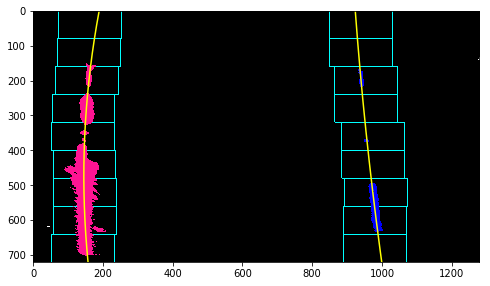

In [138]:
#Perspective transform and Gradient tresholding
img1 = cv2.imread('test_images/_test5.jpg')
warped1=warp_transform(img1)
binary_warped = color_transformation(warped1)
# Find our lane pixels first

left_fit, right_fit, left_lane_inds, right_lane_inds, rectangles = find_lane_pixels(binary_warped)
out_img = np.uint8(np.dstack((binary_warped, binary_warped, binary_warped))*255)
# Generate x and y values for plotting
ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
# Draw the windows on the visualization image
for xy in rectangles:
    cv2.rectangle(out_img,(xy[2],xy[0]),(xy[3],xy[1]),(0,255,255), 2) 
    cv2.rectangle(out_img,(xy[4],xy[0]),(xy[5],xy[1]),(0,255,255), 2) 
# Identify the x and y positions of all nonzero pixels in the image
nonzero = binary_warped.nonzero()
nonzeroy = np.array(nonzero[0])
nonzerox = np.array(nonzero[1])
# Extract left and right line pixel positions
leftx = nonzerox[left_lane_inds]
lefty = nonzeroy[left_lane_inds] 
rightx = nonzerox[right_lane_inds]
righty = nonzeroy[right_lane_inds] 
    ## Visualization ##
# Colors in the left and right lane regions
out_img[lefty, leftx] =  [255,20,147]
out_img[righty, rightx] = [0, 0, 255 ]
# Plots the left and right polynomials on the lane lines
plt.figure(figsize=(8,12))
plt.plot(left_fitx, ploty, color='yellow')
plt.plot(right_fitx, ploty, color='yellow')
plt.imshow(out_img)

### 5.Determine the curvature of the lane and vehicle position with respect to center.

In [124]:

def measure_curvature_real(warped_image, left_lane_ids, right_lane_ids):
    ploty = np.linspace(0, warped_image.shape[0]-1, warped_image.shape[0])
    y_eval = np.max(ploty)
    
    # find nonzero pixels
    nonzero = warped_image.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    
    # extract left and right line pixel positions
    leftx = nonzerox[left_lane_ids]
    lefty = nonzeroy[left_lane_ids] 
    rightx = nonzerox[right_lane_ids]
    righty = nonzeroy[right_lane_ids]
   
    ym_per_px = 30/720 # meters per pixel in y dimension
    xm_per_px = 3.7/900 # meters per pixel in x dimension

    # Fit new polynomials to x,y in world space
    left_fit_cr = np.polyfit(lefty*ym_per_px, leftx*xm_per_px, 2)
    right_fit_cr = np.polyfit(righty*ym_per_px, rightx*xm_per_px, 2)
    
    left_curverad = ((1 + (2*left_fit_cr[0]*y_eval*ym_per_px + left_fit_cr[1])**2)**1.5) / np.absolute(2*left_fit_cr[0])
    right_curverad = ((1 + (2*right_fit_cr[0]*y_eval*ym_per_px + right_fit_cr[1])**2)**1.5) / np.absolute(2*right_fit_cr[0])
    
    #distance from center: (min X point from the left+ max point x from the right )/2 -middle line 
    car_position = warped_image.shape[1]//2
    center_line = (min(leftx) + max(rightx))//2
    distance = np.abs(car_position - center_line) * xm_per_px
    
    return  left_curverad, right_curverad, distance
    

In [125]:

def fill_area(img, bin_img, left_fit_poly, right_fit_poly):
    img_copy = np.copy(img)
    ploty = np.linspace(0, bin_img.shape[0]-1, bin_img.shape[0])
    
    # Create an image to draw the lines on
    warp_zero = np.zeros_like(bin_img).astype(np.uint8)
    color_warp = np.dstack((warp_zero, warp_zero, warp_zero))
    
    # fit lines
    left_fitx = left_fit_poly[0]*ploty**2 + left_fit_poly[1]*ploty + left_fit_poly[2]
    right_fitx = right_fit_poly[0]*ploty**2 + right_fit_poly[1]*ploty + right_fit_poly[2]

    # Recast the x and y points into usable format for cv2.fillPoly()
    pts_left = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
    pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))])
    pts = np.hstack((pts_left, pts_right))

    # Draw the lane onto the warped blank image
    cv2.fillPoly(color_warp, np.int_([pts]), (0,255, 0))
    Minv = cv2.getPerspectiveTransform(dst, src)
    # Warp the blank back to original image space using inverse perspective matrix (Minv)
    newwarp = cv2.warpPerspective(color_warp, Minv, (img_copy.shape[1], img_copy.shape[0])) 
    # Combine the result with the original image
    result = cv2.addWeighted(img_copy, 1, newwarp, 0.3, 0)
    
    return result

def write_data(image, left_curverad, right_curverad, distance):
    image_copy=np.copy(image)
    left_text = "Left Curve Radius: {0:.2f}m".format(left_curverad)
    right_text = "Right Curve Radius: {0:.2f}m".format(right_curverad)
    dist_text = "Distance from Center: {0:.2f}m".format(distance)
    #define font param
    font = cv2.FONT_HERSHEY_SIMPLEX
    fontColor = (255, 255, 255)
    cv2.putText(image_copy, left_text, (50,90), font, 1.25, fontColor, 2)
    cv2.putText(image_copy, right_text,(50,140), font, 1.25,fontColor,2)
    cv2.putText(image_copy, dist_text, (50,190), font, 1.25, fontColor, 2)

    return image_copy

### 6.Pipeline ImageFile:

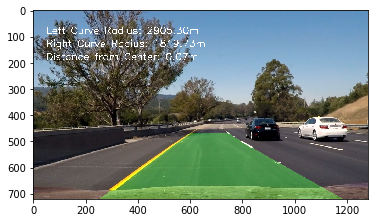

In [139]:
img = cv2.imread('test_images/test6.jpg')

image_correction=distortion_correction(img)
warped= warp_transform(image_correction)

color_binary= color_transformation(warped)

left_fit, right_fit, left_lane_inds, right_lane_inds, rectangles = find_lane_pixels(color_binary)
                                                                                    
img1 = fill_area(img, color_binary, left_fit, right_fit)
                                                                                    
left_radius,right_radius,distance = measure_curvature_real(color_binary, left_lane_inds, right_lane_inds)
                                                                                    
img2 = write_data(img1, left_radius,right_radius,distance)
img2 = cv2.cvtColor(img2, cv2.COLOR_BGR2RGB)
plt.imshow(img2)
plt.imsave("output_images/_test6.jpg",img2)

### 7.Pipeline VideoFile:


In [140]:
def process_image(image):
    #0.Correction distortion
    image_correction=distortion_correction(image)
    #1.After correction distortion apply perspective transform
    warped= warp_transform(image_correction)
    #2.Color transformation
    color_binary= color_transformation(warped)
    #Find lane pixels
    left_fit, right_fit, left_lane_inds, right_lane_inds, rectangles =find_lane_pixels(color_binary)
    #left_fit_new, right_fit_new, left_lane_inds, right_lane_inds=refit(color_binary, left_fit_prev, right_fit_prev):
    
    out_vis= visualize(color_binary, left_fit,right_fit, left_lane_inds, right_lane_inds,rectangles)
    
    #Fill area of interes
    new_image= fill_area(image, color_binary, left_fit, right_fit)
    #Extract radius of curvature and vehicle position
    left_curverad, right_curverad, distance= measure_curvature_real(color_binary, left_lane_inds, right_lane_inds)
    #Write the data on image
    result = write_data(new_image, left_curverad, right_curverad, distance)
    
    
    output = result# function that warp image back to perspective view

    output1 = cv2.resize(np.dstack((color_binary, color_binary, color_binary))
                         * 255, (640, 360), interpolation=cv2.INTER_AREA)
    #output2 = cv2.resize(np.dstack((out_vis, out_vis, out_vis))
                         #* 255, (640, 360), interpolation=cv2.INTER_AREA)
    output2 = cv2.resize(out_vis,(640, 360), interpolation = cv2.INTER_AREA)
    #output1=cv2.resize(color_binary,(640, 360), interpolation = cv2.INTER_AREA)
    #output2 = cv2.resize(warped,(640, 360), interpolation = cv2.INTER_AREA)
   
    # Create an array big enough to hold both images next to each other.
    vis = np.zeros((720, 1280+640, 3))

    # Copy both images into the composed image.
    vis[:720, :1280,:] = output
    vis[:360, 1280:1920,:] = output1
    vis[360:720, 1280:1920,:] = output2
    return vis

In [141]:
from moviepy.editor import VideoFileClip
from IPython.display import HTML

In [142]:
first_frame=0
last_left_fit=np.array([1,1,1])
last_right_fit=np.array([1,1,1])

In [143]:
white_output = 'project_video_output.mp4'
clip1 = VideoFileClip("project_video.mp4")
white_clip = clip1.fl_image(process_image)
%time white_clip.write_videofile(white_output, audio=False)

[MoviePy] >>>> Building video project_video_output.mp4
[MoviePy] Writing video project_video_output.mp4



 24%|██▍       | 303/1261 [01:44<05:49,  2.74it/s]


 41%|████▏     | 521/1261 [03:01<04:27,  2.77it/s]

right skip
right skip



 65%|██████▌   | 823/1261 [04:49<02:37,  2.79it/s]


 78%|███████▊  | 988/1261 [05:47<01:43,  2.64it/s]

right skip
right skip



 82%|████████▏ | 1037/1261 [06:07<01:24,  2.66it/s]

right skip
right skip



 82%|████████▏ | 1038/1261 [06:07<01:24,  2.63it/s]

right skip
right skip



100%|█████████▉| 1260/1261 [07:29<00:00,  2.76it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: project_video_output.mp4 

CPU times: user 4min 45s, sys: 2.09 s, total: 4min 47s
Wall time: 7min 33s


In [144]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(white_output))